In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

features, targets = load_breast_cancer(return_X_y=True)
print(features.shape, targets.shape)

scaler = StandardScaler()
features = scaler.fit_transform(features)

(569, 30) (569,)


# **1) Diminsionality Reduction**

### 1.1) Using PCA (Principal Component Analysis)

In [ ]:
pca = PCA(n_components=5)
pca.fit(features)
features_pca = pca.transform(features)

In [ ]:
features_pca.shape

(569, 5)

### 1.2) Using Autoencoders (Linear Layers)

In [ ]:
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(30,)), # ** Input Shape: 30 Features
    tf.keras.layers.Dense(128,),
    tf.keras.layers.Dense(64,),
    tf.keras.layers.Dense(32,),
    tf.keras.layers.Dense(5,), # Latent representation
], name='encoder')

decoder = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(5,)),
    tf.keras.layers.Dense(256, ),
    tf.keras.layers.Dense(128, ),
    tf.keras.layers.Dense(64, ),
    tf.keras.layers.Dense(30), # ** Output Shape: 30 Features
], name='decoder')

autoencoder = tf.keras.models.Sequential([encoder, decoder],
                                         name='autoencoder')

autoencoder.compile(loss='mse', optimizer='adam')

autoencoder.fit(features, features,
                epochs=1000,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss')],
                verbose=1)

Epoch 1/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 413ms/step - loss: 0.8547
Epoch 2/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3066 
Epoch 3/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1799 
Epoch 4/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1710 
Epoch 5/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1663 
Epoch 6/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1593 


In [ ]:
# Encoding
features_ae = encoder.predict(features)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [ ]:
print(features_pca.shape)
print(features_ae.shape)

(569, 5)
(569, 5)


### Compare the Latent Representation

In [ ]:
print(features_pca.shape)
print(features_ae.shape)

# Apply Mean Squared Errors (MSE)
delta_latent = np.mean(np.square(features_pca - features_ae))
print(f'Comparing the two "latent representations" using MSE: {round(delta_latent, 2)}.')

(569, 5)
(569, 5)
Comparing the two "latent representations" using MSE: 5.98.


### Reconstruction (Decoding)

In [ ]:
reconstruction_pca = pca.inverse_transform(features_pca)
reconstruction_ae = decoder.predict(features_ae)

delta_reconstruction = np.mean(np.square(reconstruction_pca
                                         - reconstruction_ae))

mse_reconstruction_pca = np.mean(np.square(reconstruction_pca
                                            - features))
mse_reconstruction_ae = np.mean(np.square(reconstruction_ae
                                          - features))


print(
    f'Reconstructions Comparison '
    f'{round(delta_reconstruction, 3)}'
)
print(f'\t1) PCA reconstruction MSE = {round(mse_reconstruction_pca, 3)}')
print(f'\t2) AE reconstruction MSE = {round(mse_reconstruction_ae, 3)}')


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Reconstructions Comparison 0.012
	1) PCA reconstruction MSE = 0.153
	2) AE reconstruction MSE = 0.164


# **Conclusion:** *AE generalizes PCA — a linear AE ≈ PCA*.


### 1.3) Nonlinear AE

In [ ]:
encoder_nl = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(30,)),
    tf.keras.layers.Dense(128, activation='relu',),
    tf.keras.layers.Dense(64, activation='relu',),
    tf.keras.layers.Dense(32, activation='relu',),
    tf.keras.layers.Dense(5,),
], name='encoder')

decoder_nl = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(5,)),
    tf.keras.layers.Dense(256, activation='relu', ),
    tf.keras.layers.Dense(128, activation='relu',),
    tf.keras.layers.Dense(64, activation='relu',),
    tf.keras.layers.Dense(30,),
], name='decoder')

autoencoder_nl = tf.keras.models.Sequential([encoder_nl, decoder_nl],
                                            name='autoencoder')
autoencoder_nl.compile(loss='mse', optimizer='adam')

callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss')
autoencoder_nl.fit(features,
                   features, epochs=10000,
                   callbacks=[callbacks], verbose=0)
features_ae_nl = encoder_nl.predict(features)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [ ]:
reconstruction_ae_nl = decoder_nl.predict(features_ae_nl)
mse_reconstruction_ae_nl = np.mean(np.square(reconstruction_ae_nl - features))

print(f'\nMSE of reconstructions:')
print(f'\t1) PCA recon MSE = {round(mse_reconstruction_pca, 3)}')
print(f'\t2) AE (linear) recon MSE = {round(mse_reconstruction_ae, 3)}')
print(f'\t2) AE (nonlinear) recon MSE = {round(mse_reconstruction_ae_nl, 3)}')


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step

MSE of reconstructions:
	1) PCA recon MSE = 0.153
	2) AE (linear) recon MSE = 0.164
	2) AE (nonlinear) recon MSE = 0.115


# **2) Anomalies Detection**

In [ ]:
# Load MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32")/255.
x_test  = x_test.astype("float32")/255.

x_train = np.expand_dims(x_train, -1)
x_test  = np.expand_dims(x_test, -1)

# Train only on digit "1" (normal data)
normal_train = x_train[y_train == 1]
normal_test  = x_test[y_test == 1]
anomalies    = x_test[y_test != 1]

normal_train.shape

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


(6742, 28, 28, 1)

In [ ]:
print(len(normal_train), len(anomalies))

6742 8865


In [ ]:
#@title Build a Small Autoencoder
from tensorflow.keras import layers, models

encoder = models.Sequential([
    layers.Input(shape=(28,28,1)),
    layers.Flatten(),
    layers.Dense(32, activation="relu")
])

decoder = models.Sequential([
    layers.Input(shape=(32,)),
    layers.Dense(28*28, activation="sigmoid"),
    layers.Reshape((28,28,1))
])

autoencoder = models.Sequential([encoder, decoder])

autoencoder.compile(optimizer="adam", loss="mse")

es =tf.keras.callbacks.EarlyStopping(monitor='loss')
# Train on Normal Data Only
autoencoder.fit(normal_train, normal_train, callbacks=[es],
                epochs=100, batch_size=128, verbose=1)

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.1816
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0272
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0188
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0157
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0137
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0123
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0109
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0101
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0092
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079
Epoch 12/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077
Epoch 13/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072
Epoch 14/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068
Epoch 15/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065
Epo

### Compute Threshold
```
threshold= μ + k⋅σ
```
- `μ` = mean reconstruction error on normal data
- `σ` = standard deviation of reconstruction error
- `k` = multiplier (commonly 2, 3, or tuned on validation data)
- `k=2` → catches moderate anomalies
- `k=3` → very strict; only extreme errors flagged

![](https://miro.medium.com/1*Xk7pnbtAmpCSNxtpKznpeg.png)

In [ ]:
recons = autoencoder.predict(normal_test)

errors = np.mean((recons - normal_test)**2, axis=(1,2,3))

threshold = np.mean(errors) + 3*np.std(errors)

print("Threshold:", threshold)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Threshold: 0.009588523


In [ ]:
#@title Detect Anomalies

# Normal samples → low reconstruction error
# Abnormal samples → high reconstruction error

test_recons = autoencoder.predict(anomalies)
test_errors = np.mean((test_recons - anomalies)**2, axis=(1,2,3))

anomaly_detected = test_errors > threshold
print("Detection rate:", anomaly_detected.mean())


278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Detection rate: 0.9977439368302312


- Autoencoders learn normality, not anomalies

- Anomalies produce large reconstruction errors

- Need to establish a good threshold

- Works exceptionally well for images, time-series, and audio

- Fully unsupervised – no labels required

# 3) Denoising AEs

In [ ]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor*np.random.normal(size=x_train.shape)
x_test_noisy = x_test + noise_factor*np.random.normal(size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [ ]:
history_noise = autoencoder.fit(x_train_noisy, x_train,
                          epochs=10,
                          batch_size=128)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0377
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0242
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0224
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0216
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0211
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0207
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0204
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0201
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0201
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0200


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


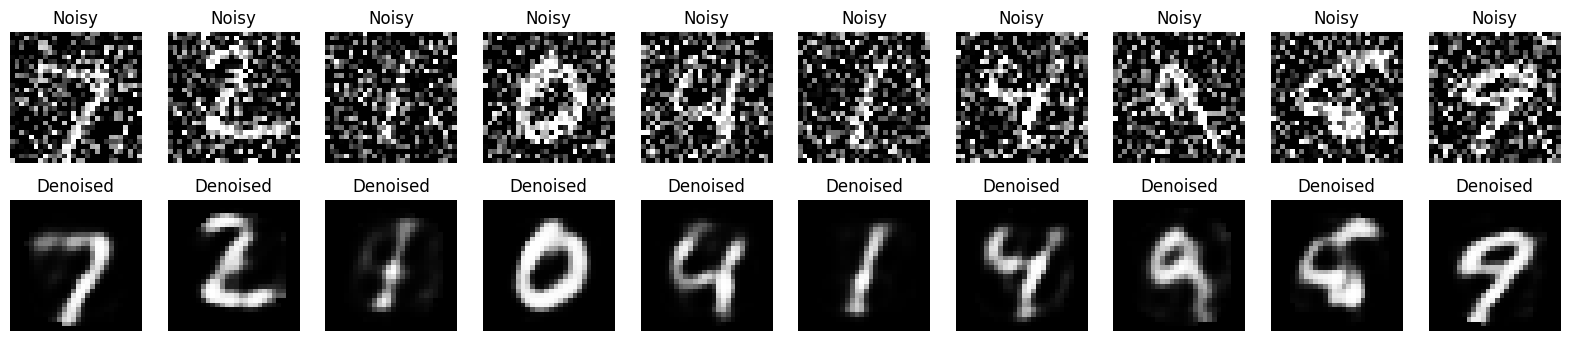

In [ ]:
n = 10
plt.figure(figsize=(20,4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28,28), cmap="gray")
    plt.title("Noisy")
    plt.axis("off")

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(autoencoder.predict(x_test_noisy[i:i+1]).reshape(28,28), cmap="gray")
    plt.title("Denoised")
    plt.axis("off")

# 4) Convolutional Autoencoders

In [ ]:
# Load Fashion MNIST

(x_train, y_train), (x_test, y_test) = (
    tf.keras.datasets.fashion_mnist.load_data()
)

x_train, x_test = x_train / 255, x_test / 255

x_train = np.expand_dims(x_train, -1)
x_test  = np.expand_dims(x_test, -1)

print(x_train.shape, x_test.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
(60000, 28, 28, 1) (10000, 28, 28, 1)


In [ ]:
encoder_cnn = models.Sequential([
    layers.Input(shape=(28,28,1)),
    layers.Conv2D(16,kernel_size=(3, 3), activation='relu', padding='same',strides=2,),
    layers.Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same', strides=2),
],name='encoder')

decoder_cnn = tf.keras.models.Sequential([
    layers.Input(shape=(7, 7, 8)),
    layers.Conv2DTranspose(8,3,strides=2,activation='relu', padding='same'),
    layers.Conv2DTranspose(16, 3, strides=2, activation='relu', padding='same'),
    layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same'),
],name='decoder')

autoencoder_cnn = tf.keras.models.Sequential([encoder_cnn, decoder_cnn],
                                         name='autoencoder')
encoder.summary()
decoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │        25,120 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,120 (98.12 KB)

 Trainable params: 25,120 (98.12 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 784)            │        25,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,872 (101.06 KB)

 Trainable params: 25,872 (101.06 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor*np.random.normal(size=x_train.shape)
x_test_noisy = x_test + noise_factor*np.random.normal(size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [ ]:
autoencoder_cnn.compile(loss='mse', optimizer='adam')

es = tf.keras.callbacks.EarlyStopping(monitor='loss')
autoencoder_cnn.fit(x_train_noisy, x_train,
                validation_data=(x_test_noisy, x_test),epochs=10,
                callbacks = [es], verbose=1)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0497 - val_loss: 0.0214
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0212 - val_loss: 0.0209
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0205 - val_loss: 0.0200
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0199 - val_loss: 0.0196
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0195 - val_loss: 0.0194
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0193 - val_loss: 0.0192
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0191 - val_loss: 0.0191
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0190 - val_loss: 0.0190
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0189 - val_loss: 0.0192
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0188 - val_loss: 0.0188


In [ ]:
x_test_encoded = encoder_cnn.predict(x_test)
print(x_test_encoded.shape)
x_test_decoded = decoder_cnn.predict(x_test_encoded)
print(x_test_decoded.shape)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(10000, 7, 7, 8)
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
(10000, 28, 28, 1)


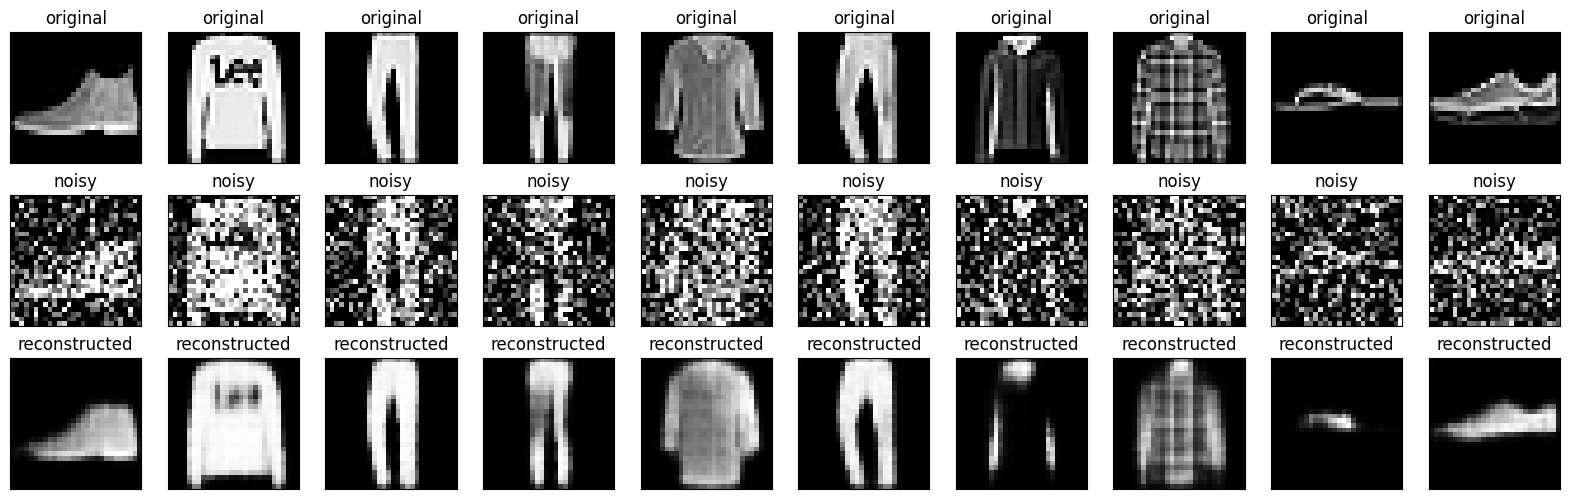

In [ ]:
n=10
plt.figure(figsize=(20, 6))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i][:, :, 0])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i][:, :, 0])
    plt.title("noisy")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + n+n)
    plt.imshow(x_test_decoded[i][:, :, 0])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Denoising Autoencoder